In [1]:
from datasets import TrainDataset, TestDataset, ValDataset
import transforms as tran
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from hubmap.data import DATA_DIR

In [ ]:
train_for_cal = TrainDataset(DATA_DIR, transform=tran.ToTensor())
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
count = len(train_for_cal) * 512 * 512
loader_for_cal = DataLoader(train_for_cal, batch_size=32, shuffle=False)

In [ ]:
for inputs, mask in loader_for_cal:
    psum += inputs.sum(axis=[0, 2, 3])
    psum_sq += (inputs**2).sum(axis=[0, 2, 3])

In [ ]:
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)

In [ ]:
transforms_augment = tran.Compose(
    [
        tran.ToTensor(mask_as_integer=True),
        tran.RandomHorizontalFlip(),
        tran.RandomVerticalFlip(),
        tran.Normalize(total_mean, total_std),
    ]
)

transforms_val = tran.Compose(
    [tran.ToTensor(mask_as_integer=True), tran.Normalize(total_mean, total_std)]
)

In [ ]:
train = TrainDataset(
    DATA_DIR, transform=transforms_augment, with_background=True, as_id_mask=True
)
# test = TestDataset('../data/', transform=transforms, with_background=True, as_id_mask=True)
val = ValDataset(
    DATA_DIR, transform=transforms_val, with_background=True, as_id_mask=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


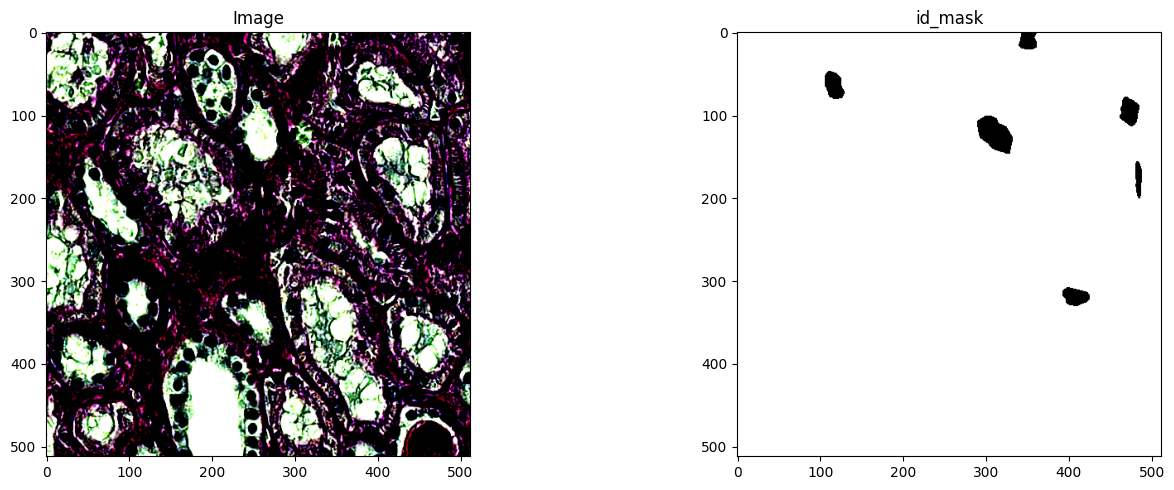

In [ ]:
train.plot_example(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


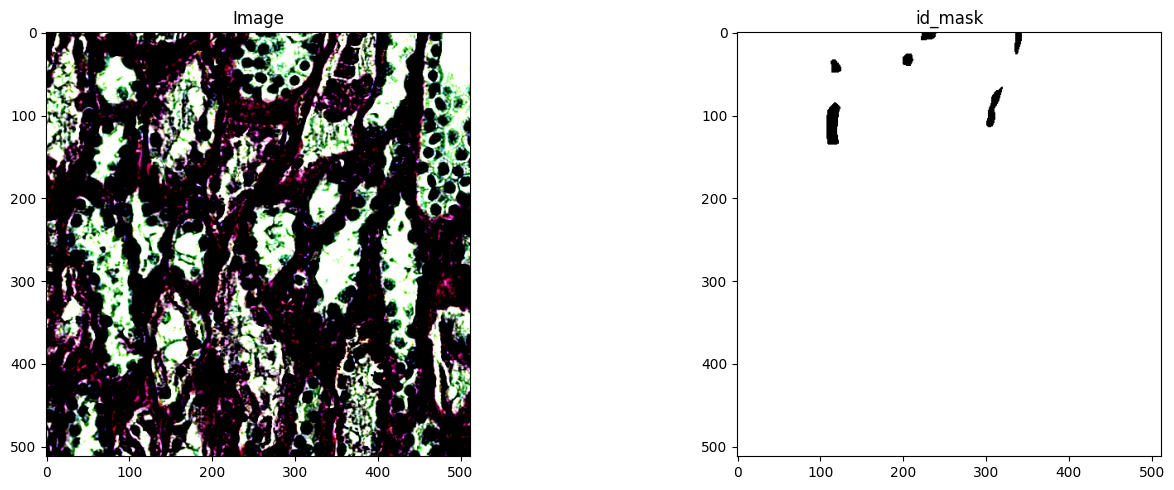

In [ ]:
val.plot_example(10)

In [ ]:
batch_size = 2
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

In [ ]:
from transformers import SegformerForSemanticSegmentation

ModuleNotFoundError: No module named 'transformers'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b2",
    num_labels=4,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 20
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.squeeze(1).long().to(device)
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        upsampled_logits = nn.functional.interpolate(
            outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1)

        # i only care about blood vessel accuracy
        mask = labels == 0

        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        running_loss += loss.item()

    train_accuracy.append(100 * correct / total if total != 0 else 0)
    train_loss.append(running_loss / i)

    # Testing
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        labels = labels.squeeze(1).long().to(device)
        inputs = inputs.to(device)
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss

        upsampled_logits = nn.functional.interpolate(
            outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1)

        mask = labels == 0
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        running_loss += loss.item()

    test_accuracy.append(100 * correct / total if total != 0 else 0)
    test_loss.append(running_loss / i)

    print(
        f"Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Train Acc: {train_accuracy[-1]}, Test Loss: {test_loss[-1]}, Test Acc: {test_accuracy[-1]}"
    )

In [ ]:
from skimage.color import label2rgb
import torchvision.transforms as T
import numpy as np

In [ ]:
image, target = val.get(5, transform=tran.ToTensor(mask_as_integer=True))
input, mask = val.get(5, transform=val.transform)
input = input.unsqueeze(0).to(device)
mask = mask.to(device).long()
model.eval()
with torch.no_grad():
    outputs = model(pixel_values=input, labels=mask.long())

upsampled_logits = nn.functional.interpolate(
    outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
)
predicted = upsampled_logits.argmax(dim=1)


toPILImage = T.ToPILImage()
imagePIL = toPILImage(image)
image_np = np.array(imagePIL)

targetPIL = toPILImage(target.byte())
target_np = np.array(targetPIL)

predictedPIL = toPILImage(predicted.byte())
predicted_np = np.array(predictedPIL)

image_label_overlay = label2rgb(
    target_np,
    image=image_np,
    bg_label=3,
    colors=["red", "green", "blue"],
    kind="overlay",
    saturation=1.0,
)


image_predicted_overlay = label2rgb(
    predicted_np,
    image=image_np,
    bg_label=3,
    colors=["red", "green", "blue"],
    kind="overlay",
    saturation=1.0,
)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image_label_overlay)
ax[0].set_title("Target Labels")

ax[1].imshow(image_predicted_overlay)
ax[1].set_title("Predicted Labels")

plt.show()

In [ ]:
image_label_overlay = label2rgb(
    predicted_np,
    image=image_np,
    bg_label=3,
    colors=["red", "green", "blue"],
    kind="overlay",
    saturation=1.0,
)


plt.imshow(image_label_overlay)